This notebook is used as the backend server for the anvil application.    
Allows to user uploaded semantic images on the pretrained model.  

Application is at: https://by5m6vsbgfepw2t3.anvil.app/JMO2B7YNIGG7GD6ASRJFWUAY

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 231 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=3feec1b3db01ebedf247878ee9a2367e2e37bcdfbec746d2aa4614141f74c6bd
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


In [4]:
! git clone "https://github.com/boschresearch/OASIS"
! git clone "https://github.com/google-research/deeplab2.git"

Cloning into 'OASIS'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 232 (delta 88), reused 80 (delta 74), pack-reused 121
Receiving objects: 100% (232/232), 13.08 MiB | 25.17 MiB/s, done.
Resolving deltas: 100% (133/133), done.
Cloning into 'deeplab2'...
remote: Enumerating objects: 1546, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 1546 (delta 184), reused 161 (delta 151), pack-reused 1300
Receiving objects: 100% (1546/1546), 7.32 MiB | 22.24 MiB/s, done.
Resolving deltas: 100% (1037/1037), done.


In [5]:
#imports
import numpy as np
import random
import torch
from torchvision import transforms as TR
#from torchinfo import summary
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
from types import SimpleNamespace
import os
import sys
import io
import scipy
from scipy import linalg

sys.path.append(os.path.abspath("/content/drive/MyDrive/ProjectGAN"))
sys.path.append(os.path.abspath("/content/OASIS"))
print(sys.path)
import OASIS

import models.models as models
import models.losses as losses
import dataloaders.dataloaders as dataloaders
import utils.utils as utils
from utils.fid_scores import fid_pytorch
import config
from constants import root_project_directory
from my_dataloaders import get_dataloaders
from my_utils import configure_arguments

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/ProjectGAN', '/content/OASIS']


In [6]:
def custom_arguments(opt):
  #opt.your-argument-here = value
  #opt.name = "oasis_cityscapes_pretrained"
  opt.dataroot = "/content/drive/MyDrive/ProjectGAN/datasets/cityscapes"
  opt.gpu_ids = "-1"
  #opt.segmentation = "semantic"   #the application can only take semantic annotations
  pass

In [7]:
def get_default_opt(train):
  #do not change these parameters
  opt = SimpleNamespace(
      #--- general options ---gdfsgds
      name="oasis_cityscapes_pretrained",                                     # name of the experiment. It decides where to store samples and models
      seed=42,                                                                # random seed
      segmentation="semantic",                                                # use semantic or panoptic segmentation for training
      gpu_ids='0',                                                            # gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU
      checkpoints_dir=root_project_directory+"/pretrained_checkpoints",       # models are saved here
      no_spectral_norm=False,                                                 # this option deactivates spectral norm in all layers
      batch_size=20,                                                          # input batch size
      dataroot=root_project_directory+"/dataset",                             # path to dataset root
      dataset_mode="cityscapes",                                              # this option indicates which dataset should be loaded
      no_flip=False,                                                          # if specified, do not flip the images for data argumentation
      #--- generator options ---
      num_res_blocks=6,                                                       # number of residual blocks in G and D
      channels_G=64,                                                          # number of gen filters in first conv layer in generator
      param_free_norm="syncbatch",                                            # which norm to use in generator before SPADE
      spade_ks=3,                                                             # kernel size of convs inside SPADE
      no_EMA=False,                                                           # if specified, do *not* compute exponential moving averages
      EMA_decay=0.9999,                                                       # decay in exponential moving averages
      no_3dnoise=False,                                                       # if specified, do *not* concatenate noise to label maps
      z_dim=64)                                                               # dimension of the latent z vector
  
  if train:
    opt_extra = SimpleNamespace(
        freq_print=1000,                                                      # frequency of showing training results
        freq_save_ckpt=20000,                                                 # frequency of saving the checkpoints
        freq_save_latest=10000,                                               # frequency of saving the latest model
        freq_smooth_loss=250,                                                 # smoothing window for loss visualization
        freq_save_loss=2500,                                                  # frequency of loss plot updates
        freq_fid=5000,                                                        # frequency of saving the fid score (in training iterations)
        continue_train=True,                                                  # resume previously interrupted training
        which_iter='latest',                                                  # which epoch to load when continue_train
        num_epochs=10,                                                        # number of epochs to train
        beta1=0.0,                                                            # momentum term of adam
        beta2=0.999,                                                          # momentum term of adam
        lr_g=0.0001,                                                          # G learning rate
        lr_d=0.0004,                                                          # D learning rate

        channels_D=64,                                                        # number of discrim filters in first conv layer in discriminator
        add_vgg_loss=False,                                                   # if specified, add VGG feature matching loss
        lambda_vgg=10.0,                                                      # weight for VGG loss
        no_balancing_inloss=False,                                            # if specified, do *not* use class balancing in the loss function
        no_labelmix=False,                                                    # if specified, do *not* use LabelMix
        lambda_labelmix=10.0                                                  # weight for LabelMix regularization
    )
  else:
    opt_extra = SimpleNamespace(
        results_dir=root_project_directory+"/results/",                       # saves testing results here.
        ckpt_iter='best'                                                      # which epoch to load to evaluate a model
    )
  opt = SimpleNamespace(**opt.__dict__, **opt_extra.__dict__)       # conactenate all options
  opt.phase = 'train' if train else 'test'
  opt.loaded_latest_iter=None;
  return opt

In [8]:
opt = configure_arguments(custom_arguments, train=False)
dataloader, dataloader_val = get_dataloaders(opt)
model = models.OASIS_model(opt)
model.eval()

----------------- Options ---------------
                EMA_decay: 0.9999                        
               batch_size: 20                            
               channels_G: 64                            
          checkpoints_dir: /content/drive/MyDrive/ProjectGAN/pretrained_checkpoints
                ckpt_iter: best                          
                 dataroot: /content/drive/MyDrive/ProjectGAN/datasets/cityscapes	[default: /content/drive/MyDrive/ProjectGAN/dataset]
             dataset_mode: cityscapes                    
                  gpu_ids: -1                            	[default: 0]
       loaded_latest_iter: None                          
                     name: oasis_cityscapes_pretrained   
               no_3dnoise: False                         
                   no_EMA: False                         
                  no_flip: False                         
         no_spectral_norm: False                         
           num_res_blocks: 6   

OASIS_model(
  (netG): OASIS_Generator(
    (conv_img): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (up): Upsample(scale_factor=2.0, mode=nearest)
    (body): ModuleList(
      (0): ResnetBlock_with_SPADE(
        (conv_0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm_0): SPADE(
          (first_norm): SynchronizedBatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (mlp_shared): Sequential(
            (0): Conv2d(99, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
          )
          (mlp_gamma): Conv2d(128, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (mlp_beta): Conv2d(128, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm_1): SPADE(
          (first_norm): SynchronizedBatchNorm2d(1024, eps=1e-05, momentum=0

In [9]:
def preprocess_input(opt, label):
    label = label.long()
    if opt.gpu_ids != "-1":
        label = label.cuda()
    label_map = label
    bs, _, h, w = label_map.size()
    nc = opt.semantic_nc
    if opt.gpu_ids != "-1":
        input_label = torch.cuda.FloatTensor(bs, nc, h, w).zero_()
    else:
        input_label = torch.FloatTensor(bs, nc, h, w).zero_()
    if (opt.segmentation == "panoptic"):
      semantic_map = torch.div(label_map, 1000, rounding_mode="floor")
      semantic_map = semantic_map.masked_fill_(semantic_map==255, 19)
      instance_map = torch.fmod(label_map, 1000.0) + 1.0
      input_semantics = input_label.scatter_(1, semantic_map, instance_map)
    else:
      input_semantics = input_label.scatter_(1, label_map, 1.0)
    return input_semantics

In [10]:
from torchvision import transforms as TR
def transforms(opt, label):
    # resize
    new_width, new_height = (int(opt.load_size / opt.aspect_ratio), opt.load_size)
    label = TR.functional.resize(label, (new_width, new_height), Image.NEAREST)
    # to tensor
    label = TR.functional.to_tensor(label)[None,...]
    return label

In [11]:
import anvil.server
import anvil.media
anvil.server.connect("WC2Y6FYL6RGTFZWLSYZCW7HI-BY5M6VSBGFEPW2T3")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [12]:
def tens_to_im(tens):
    out = (tens + 1) / 2
    out.clamp(0, 1)
    out = out.detach().cpu().numpy()
    return np.transpose(out, (1, 2, 0))

In [13]:
def colored_to_label(colored):
  color_to_id = { 
    (  0,  0,  0):0,
    (111, 74,  0):5,
    ( 81,  0, 81):6,
    (128, 64,128):7,
    (244, 35,232):8,
    (250,170,160):9,
    (230,150,140):10,
    ( 70, 70, 70):11,
    (102,102,156):12,
    (190,153,153):13,
    (180,165,180):14,
    (150,100,100):15,
    (150,120, 90):16,
    (153,153,153):17,
    (250,170, 30):19,
    (220,220,  0):20,
    (107,142, 35):21,
    (152,251,152):22,
    ( 70,130,180):23,
    (220, 20, 60):24,
    (255,  0,  0):25,
    (  0,  0,142):26,
    (  0,  0, 70):27,
    (  0, 60,100):28,
    (  0,  0, 90):29,
    (  0,  0,110):30,
    (  0, 80,100):31,
    (  0,  0,230):32,
    (119, 11, 32):33,}
  colored = np.asarray(colored)
  label = np.zeros_like(colored)
  for k in color_to_id:
    label[np.equal(colored, np.array(k))] = color_to_id[k]
  return Image.fromarray(label)

In [14]:

@anvil.server.callable
def run_prediction(file):
  with anvil.media.TempFile(file) as f:
    colored = Image.open(f)#.convert("RGB")
  print(colored.mode)
  label = colored
  print(type(label))
  print(label.size)
  #label = colored_to_label(colored)
  plt.imshow(label)
  plt.show()
  label = transforms(opt, label)
  label = label * 255
  input_semantics = preprocess_input(opt, label)
  tens = model(None, input_semantics, "generate", None)
  img_np = tens_to_im(tens[0])
  plt.figure()
  plt.subplot()
  plt.imshow(img_np)
  plt.show()
  img_byte_arr = io.BytesIO()
  plt.imsave(img_byte_arr, img_np, format='PNG')
  img_byte_arr = img_byte_arr.getvalue()
  media_img = anvil.BlobMedia(content_type="image/png", content=img_byte_arr)
  return media_img


L
<class 'PIL.PngImagePlugin.PngImageFile'>
(2048, 1024)


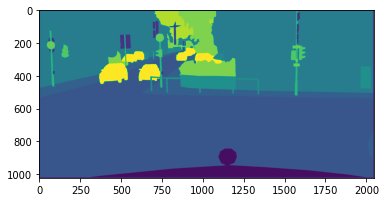

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:424: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


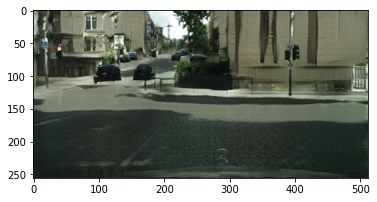

In [ ]:
anvil.server.wait_forever()